In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

scratch_path = Path().joinpath('paper', 'a2c_s80_f1_1.csv')
transfer_path = Path().joinpath('paper', 'a2c_s80_f1.0_trans50_full2_1_a2c_s80_f1.0_trans50_full2_1.csv')
scratch_data = pd.read_csv(scratch_path)[['Step', 'Value']]
trans_data = pd.read_csv(transfer_path)[['Step', 'Value']]


# mvr meaning mean-to-variance-ratio
def compute_sliding_window_mvr(values, window_size):
    mvr_list = []
    n = len(values)

    for start in range(n - window_size + 1):
        window = values[start:start + window_size]

        mean = np.mean(window)
        variance = np.var(window)  # Sample variance (ddof=1)

        if variance != 0:
            mvr = mean / variance
        else:
            mvr = float('inf')  # Handle cases with zero variance

        mvr_list.append(mvr)

    return mvr_list


def compute_sliding_window_derivative(steps, values, window_size):
    derivative_list = []
    n = len(values)

    for start in range(n - window_size + 1):
        start_value = values[start]
        end_value = values[start + window_size - 1]
        start_step = steps[start]
        end_step = steps[start + window_size - 1]

        delta_value = end_value - start_value
        delta_step = end_step - start_step

        derivative = delta_value / delta_step if delta_step != 0 else float('inf')

        derivative_list.append(derivative)

    return derivative_list


WINDOW_SIZE = 10

scratch_sliding_mvr = compute_sliding_window_mvr(scratch_data['Value'], WINDOW_SIZE)
scratch_sliding_derivative = compute_sliding_window_derivative(scratch_data['Step'], scratch_data['Value'], WINDOW_SIZE)


trans_sliding_mvr = compute_sliding_window_mvr(trans_data['Value'], WINDOW_SIZE)
trans_sliding_derivative = compute_sliding_window_derivative(trans_data['Step'], trans_data['Value'], WINDOW_SIZE)

# Results
print(scratch_sliding_mvr)
print(trans_sliding_mvr)
print(scratch_sliding_derivative)
print(trans_sliding_mvr)

[-2.9042500871901625e-06, -1.1231932904626491e-05, -2.5228010874259876e-05, -4.270223839569218e-05, -6.0871829262923596e-05, -9.165859099646097e-05, -0.00012465673803224012, -0.0001584457544771171, -0.00019647371718358784, -0.00023824314825642254, -0.00030518424969807316, -0.00037535755128427533, -0.0004464245483011891, -0.0005172015507928064, -0.0006294996883256821, -0.0007499146964566034, -0.0008707971810889239, -0.0009824088139587118, -0.001098028859281843, -0.0012842261076995202, -0.0014557888009900358, -0.0016135489727532493, -0.0018254028715313784, -0.002163600527610412, -0.0025235981189243905, -0.003004278604394179, -0.0034251012088861704, -0.00044372234970818696, -0.0002215895616468034, -0.00015079571205035418, -0.0001168251511925729, -9.922981142239668e-05, -9.090477487141108e-05, -8.908259310829082e-05, -9.622342878514818e-05, -0.00013389801076380776, -0.0013225787779131432, -0.0028152627431750833, -0.0038929951880426646, -0.005411629242370028, -0.007112180797428464, -0.01134

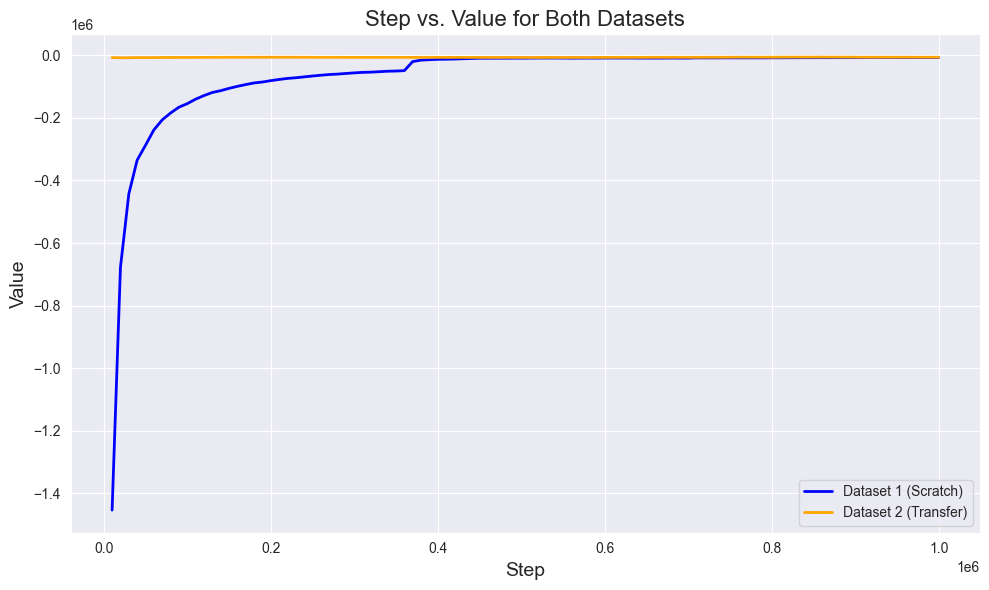

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot both datasets
sns.lineplot(data=scratch_data, x='Step', y='Value', label='Dataset 1 (Scratch)', color='blue', linewidth=2)
sns.lineplot(data=trans_data, x='Step', y='Value', label='Dataset 2 (Transfer)', color='orange', linewidth=2)

# Adding titles and labels
plt.title('Step vs. Value for Both Datasets', fontsize=16)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()